# Estimating a Gravity Model of International Trade

<b> Spark Web UI: </b> http://localhost:4040/


## Introduction

In this notebook I first estimate the gravity model as described below (plus a few additional distance metrics) using a sample of the compiled trade dataset as you would in Economics. Then I use the full dataset to train a pipeline in Spark as you would do in Data Science for a prediction task, although predicting how much a country would trade with a new, previously unknown country doesn't make much logical sense.

###  The gravity model of international trade

The gravity model of international trade was inspired by the gravity equation from physics. The basic idea is that in the same way as the attraction of two masses depends on their sizes and distance, the magnitude of trade between two nations depends on the size of their economies and their distance. Large economies produce more goods and thus can export more and need more imports for their production. Distant economies trade less with each other due to higher trade costs. 

The metric for the size of an economy is usually GDP. Distance can be measured in many (additive) ways: 
* With geographical metrics like kilometers between the capitals or centers of economic activity, the existence of a common border, or whether any country is landlocked 
* With cultural metrics like the existence of a common language, a common colonial heritage, common legal systems, being members of a same free trade zone
* The level of tariffs imposed on goods traded between two countries. Tariffs increase the distance, sort of.

For more on the gravity model see: https://en.wikipedia.org/wiki/Gravity_model_of_trade.
<br/>
<br/>
<br/>
The equation for the basic gravity model is:

$$ F_{ij}=G * \frac{M_i * M_j}{D_{ij}} * \eta_{ij} $$

Variables:
* *F(ij)*: trade volume between countries i and j
* *G*: constant
* *M(i)*: GDP of country i ("mass")
* *M(j)*: GDP of country j ("mass")
* *D(ij)*: distance between countries i and j
* *eta(ij)*: error of each country i,j pair

In order to estimate an econometric model, this equation can be transformed into the the following log-log regression equation with error epsilon(ij):
$$ ln(F_{ij}) = \beta_0 + \beta_1ln(M_i) + \beta_2ln(M_j) + \beta_3ln(D_{ij}) + \varepsilon_{ij} $$

### Description of the data

* <b>Trade flows</b>: This dataset consists of monthly data on bilateral trade flows between all EU countries and all other countries on the globe for the last 20 years plus metadata, compiled from data downloaded from [Eurostat's COMEXT database](https://ec.europa.eu/eurostat/web/international-trade-in-goods/data/focus-on-comext) with scripts in the notebook `convert-data-to-parquet.ipynb`. This dataset is about 60 GB large.
* <b>Distances and geography</b>: Data on distances and geography was downloaded from [Centre d'Études Prospectives et d'Informations Internationales (CEPII)](http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6). 
* <b>GDP</b>: GDP data was downloaded from the [World Bank](https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.KD&country=#).

## Imports

In [1]:
# Initialization and configuration
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession

# Spark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")

# Script for printing out summary statistics for linear regression models
from spark_lr_summary import lr_summary

## Initialize and configure Spark

In [2]:
# Configuration
conf = SparkConf().setAppName("Gravity").setMaster("local[4]")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g") 
conf.set("spark.executor.pyspark.memory", "2g")

# Initialization
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
spark = SparkSession(sc)

## Load and prepare data

### Flows (year 2018, aggregated to yearly values)

Explanation of variables:
* *TRADE_VOLUME*: Annual volume in mn, 2016-2018
* *TRADE_TYPE*: 'I' for intra-EU trade flows, 'E' otherwise

In [3]:
flows = spark.read.parquet("data/parquet/*")
flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter((flows["YEAR"] == 2018)) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "YEAR").agg({"VALUE_IN_EUROS": "sum"}) \

flows = flows \
    .withColumn("TRADE_VOLUME", flows["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)") \
    .fillna({"TRADE_VOLUME": 0}) \
    .cache()

In [4]:
flows.show(10)

+------------+-----------+----------+----+------------+
|REPORTER_ISO|PARTNER_ISO|TRADE_TYPE|YEAR|TRADE_VOLUME|
+------------+-----------+----------+----+------------+
|          NL|         IT|         I|2018|34334.068495|
|          NL|         PM|         E|2018|    1.361125|
|          DE|         SN|         E|2018|  129.730191|
|          DE|         NG|         E|2018| 3166.323784|
|          IT|         MM|         E|2018|   336.52542|
|          IE|         HU|         I|2018|  684.070892|
|          IE|         US|         E|2018|56030.805863|
|          IE|         KI|         E|2018|    0.006516|
|          PT|         CA|         E|2018|  543.746958|
|          PT|         AE|         E|2018|  188.316142|
+------------+-----------+----------+----+------------+
only showing top 10 rows



In [5]:
flows.printSchema()

root
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE_VOLUME: double (nullable = false)



In [6]:
# Number of observations (reporter-partner tuples)
flows.count()

6274

In [7]:
# No missing values left
flows.filter(flows.TRADE_VOLUME.isNull()).count()

0

### Distances

Explanation of variables
* *dist*: Distance between the centers of economic activity of two countries
* *comlang_off*: 1 if two countries share an official language, 0 otherwise
* *contig*: 1 if there is a contiguous border between two countries, 0 otherwise

In [8]:
distances = spark.read.csv("data/dist_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso_o", "iso_d", "contig", "comlang_off", "dist")

In [9]:
distances.show(5)

+-----+-----+------+-----------+--------+
|iso_o|iso_d|contig|comlang_off|    dist|
+-----+-----+------+-----------+--------+
|  ABW|  ABW|     0|          0|5.225315|
|  ABW|  AFG|     0|          0|13257.81|
|  ABW|  AGO|     0|          0|9516.913|
|  ABW|  AIA|     0|          0|983.2682|
|  ABW|  ALB|     0|          0|9091.742|
+-----+-----+------+-----------+--------+
only showing top 5 rows



In [10]:
distances.printSchema()

root
 |-- iso_o: string (nullable = true)
 |-- iso_d: string (nullable = true)
 |-- contig: integer (nullable = true)
 |-- comlang_off: integer (nullable = true)
 |-- dist: double (nullable = true)



In [11]:
distances.count()

50176

In [12]:
# No missing values left
print(
    distances.filter(distances.dist.isNull()).count(),
    distances.filter(distances.contig.isNull()).count(),
    distances.filter(distances.comlang_off.isNull()).count()
)

0 0 0


### Geographies

Explanation of variables:
* *landlocked*: 1 if country is landlocked, 0 otherwise

In [13]:
geographies = spark.read.csv("data/geo_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso2", "iso3", "country", "landlocked", "maincity")
    
geographies = geographies \
    .filter(geographies["maincity"] == 1) \
    .drop("maincity")

In [14]:
geographies.show(5)

+----+----+-----------+----------+
|iso2|iso3|    country|landlocked|
+----+----+-----------+----------+
|  AW| ABW|      Aruba|         0|
|  AF| AFG|Afghanistan|         1|
|  AO| AGO|     Angola|         0|
|  AI| AIA|   Anguilla|         0|
|  AL| ALB|    Albania|         0|
+----+----+-----------+----------+
only showing top 5 rows



In [15]:
geographies.printSchema()

root
 |-- iso2: string (nullable = true)
 |-- iso3: string (nullable = true)
 |-- country: string (nullable = true)
 |-- landlocked: integer (nullable = true)



In [16]:
geographies.count()

225

In [17]:
# No missing values left
geographies.filter(geographies.landlocked.isNull()).count()

0

### GDP

Explanation of variables:
* *Time*: Year
* *Value*: GDP in constant 2010 US dollars

The dataset contains 205 missing GDP values from obscure countries/territories. Filtering them out doesn't influence results in any significant way.

In [18]:
gdp = spark.read.csv("data/worldbank_gdp.csv", sep=",", header=True, inferSchema=True) \
    .select("Country Name", "Country Code", "Time", "Value")
gdp = gdp.filter(gdp.Value.isNotNull())

In [19]:
gdp.show(5)

+------------+------------+----+-------------------+
|Country Name|Country Code|Time|              Value|
+------------+------------+----+-------------------+
| Afghanistan|         AFG|2009|1.38651943147185E10|
| Afghanistan|         AFG|2010|1.58565747314411E10|
| Afghanistan|         AFG|2011|1.59241799977914E10|
| Afghanistan|         AFG|2012|1.79548771466564E10|
| Afghanistan|         AFG|2013|1.89604839698941E10|
+------------+------------+----+-------------------+
only showing top 5 rows



In [20]:
gdp.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Value: double (nullable = true)



In [21]:
gdp.count()

2440

In [22]:
# No missing values left
gdp.filter(gdp.Value.isNull()).count()

0

### Combine DataFrames

In [23]:
# flows
df = flows \
    .join(F.broadcast(geographies), flows["REPORTER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "REPORTER_ISO_3") \
    .withColumnRenamed("landlocked", "REPORTER_LANDLOCKED") \
    .drop("iso2", "country") \
    .join(F.broadcast(geographies), flows["PARTNER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "PARTNER_ISO_3") \
    .withColumnRenamed("landlocked", "PARTNER_LANDLOCKED") \
    .drop("iso2", "country")

# geography
df = df \
    .withColumn("LANDLOCKED_ANY", ((df["REPORTER_LANDLOCKED"] == 1) | (df["PARTNER_LANDLOCKED"] == 1)).cast(IntegerType())) \
    .drop("REPORTER_LANDLOCKED", "PARTNER_LANDLOCKED")

# gdp
df = df \
    .join(F.broadcast(gdp), (df["REPORTER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .withColumn("REPORTER_GDP", gdp["Value"]/1e6) \
    .drop("Country Name", "Country Code", "Time", "Value") \
    .join(F.broadcast(gdp), (df["PARTNER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .withColumn("PARTNER_GDP", gdp["Value"]/1e6) \
    .drop("Country Name", "Country Code", "Time", "Value") \
    .drop("Value")

# distance
df = df \
    .join(F.broadcast(distances), (df["REPORTER_ISO_3"] == distances["iso_o"]) & (df["PARTNER_ISO_3"] == distances["iso_d"]), how="inner") \
    .drop("iso_o", "iso_d") \
    .withColumnRenamed("dist", "DISTANCE") \
    .withColumnRenamed("contig", "COMMON_BORDER").withColumnRenamed("comlang_off", "COMMON_LANGUAGE")

# cache
data = df.drop("REPORTER_ISO_3", "PARTNER_ISO_3").cache()

## Data exploration

In [24]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,TRADE_TYPE,YEAR,TRADE_VOLUME,LANDLOCKED_ANY,REPORTER_GDP,PARTNER_GDP,COMMON_BORDER,COMMON_LANGUAGE,DISTANCE
0,NL,IT,I,2018,34334.068495,0,9.481008e+05,2.138766e+06,0,0,1297.695
1,DE,SN,E,2018,129.730191,0,3.939227e+06,2.451909e+04,0,0,4643.462
2,DE,NG,E,2018,3166.323784,0,3.939227e+06,4.693768e+05,0,0,5020.854
3,IT,MM,E,2018,336.525420,0,2.138766e+06,8.442461e+04,0,0,8264.190
4,IE,HU,I,2018,684.070892,1,3.731415e+05,1.612189e+05,0,0,1895.995


In [25]:
# Number of observations
data.count()

4595

In [26]:
# Data types
data.dtypes

[('REPORTER_ISO', 'string'),
 ('PARTNER_ISO', 'string'),
 ('TRADE_TYPE', 'string'),
 ('YEAR', 'int'),
 ('TRADE_VOLUME', 'double'),
 ('LANDLOCKED_ANY', 'int'),
 ('REPORTER_GDP', 'double'),
 ('PARTNER_GDP', 'double'),
 ('COMMON_BORDER', 'int'),
 ('COMMON_LANGUAGE', 'int'),
 ('DISTANCE', 'double')]

### Scatterplots

In [27]:
# Convert Spark dataframe to Pandas dataframe
pandasdf = data.select("REPORTER_ISO", "PARTNER_ISO", "TRADE_VOLUME", "REPORTER_GDP", "PARTNER_GDP", "DISTANCE").toPandas()

A first casual inspection confirms the expected relationships between trade volumes and GDP (positive) and GDP and distance (negative).

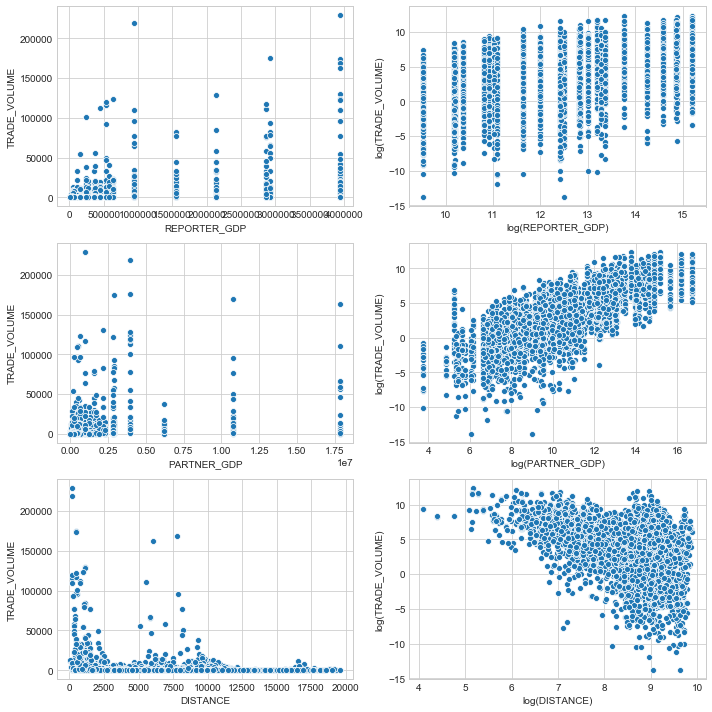

In [28]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
sns.scatterplot(x=pandasdf["REPORTER_GDP"], y=pandasdf["TRADE_VOLUME"])

plt.subplot(3,2,2)
sns.scatterplot(x=pandasdf["REPORTER_GDP"].apply(np.log), y=pandasdf["TRADE_VOLUME"].apply(np.log))
plt.xlabel("log(REPORTER_GDP)")
plt.ylabel("log(TRADE_VOLUME)")

plt.subplot(3,2,3)
sns.scatterplot(x=pandasdf["PARTNER_GDP"], y=pandasdf["TRADE_VOLUME"])

plt.subplot(3,2,4)
sns.scatterplot(x=pandasdf["PARTNER_GDP"].apply(np.log), y=pandasdf["TRADE_VOLUME"].apply(np.log))
plt.xlabel("log(PARTNER_GDP)")
plt.ylabel("log(TRADE_VOLUME)")

plt.subplot(3,2,5)
sns.scatterplot(x=pandasdf["DISTANCE"], y=pandasdf["TRADE_VOLUME"]);

plt.subplot(3,2,6)
sns.scatterplot(x=pandasdf["DISTANCE"].apply(np.log), y=pandasdf["TRADE_VOLUME"].apply(np.log));
plt.xlabel("log(DISTANCE)")
plt.ylabel("log(TRADE_VOLUME)")

plt.tight_layout()

### Distributions

None of the distributions for any variable resemble a normal distribution. There simply are much fewer really large countries than there are really small countries. Applying log transforms alleviates this problem to a varying degree - and is required for estimating the gravity equation as outlined at the start anyway. After the transform, the distribution for TRADE_VOLUME looks pretty normal, the ones for all other variables not so much.

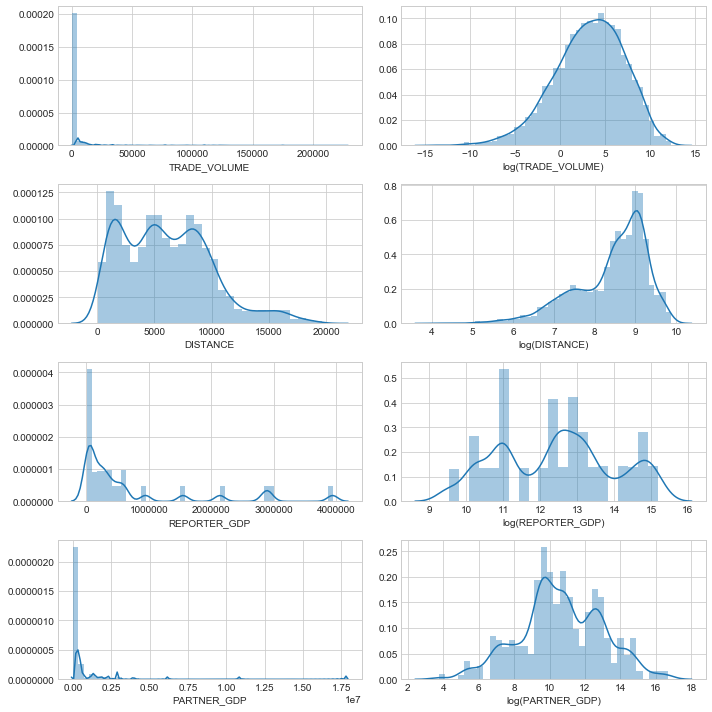

In [29]:
plt.figure(figsize=(10,10))

plt.subplot(4,2,1)
sns.distplot(pandasdf.TRADE_VOLUME)
plt.xlabel("TRADE_VOLUME")
plt.subplot(4,2,2)
sns.distplot(pandasdf.TRADE_VOLUME.apply(np.log))
plt.xlabel("log(TRADE_VOLUME)")

plt.subplot(4,2,3)
sns.distplot(pandasdf.DISTANCE)
plt.xlabel("DISTANCE")
plt.subplot(4,2,4)
sns.distplot(pandasdf.DISTANCE.apply(np.log))
plt.xlabel("log(DISTANCE)")

plt.subplot(4,2,5)
sns.distplot(pandasdf.REPORTER_GDP)
plt.xlabel("REPORTER_GDP")
plt.subplot(4,2,6)
sns.distplot(pandasdf.REPORTER_GDP.apply(np.log))
plt.xlabel("log(REPORTER_GDP)")

plt.subplot(4,2,7)
sns.distplot(pandasdf.PARTNER_GDP)
plt.xlabel("PARTNER_GDP")
plt.subplot(4,2,8)
sns.distplot(pandasdf.PARTNER_GDP.apply(np.log))
plt.xlabel("log(PARTNER_GDP)")

plt.tight_layout()

## Estimating a gravity model

Estimated equation:
$$ ln(TradeVolume_{ij}) = \beta_0 + \beta_1ln(GDP_i) + \beta_2ln(GDP_j) + \beta_3ln(Distance_{ij}) + \beta_4Landlocked_{ij} + \beta_5CommonBorder_{ij} + \beta_6CommonLanguage_{ij} + \beta_7IntraEU + \varepsilon_{ij} $$

Variables:
* *TradeVolume*: Trade volume in mn, 2018
* *GDP*: GDP in mn, 2018
* *Distance*: Distance between economic centers in km
* *LandlockedAny*: 1 if any country of a reporter-partner pair is landlocked, 0 otherwise
* *CommonBorder*: 1 if a reporter-partner pair shares a common border, 0 otherwise
* *CommonLanguage*: 1 if a reporter-partner pair shares a common official language, 0 otherwise
* *TradeType*: 'I' if both countries of a reporter-partner pair are in the EU, 'E' otherwise
* *epsilon*: Error term

Subscripts:
* *i*: Reporter 
* *j*: Partner

Sample year: 2018

### Spark pipeline

In [30]:
# Apply log transform to TRADE_VOLUME, REPORTER_GDP, PARTNER_GDP, DISTANCE
data = data \
    .withColumn("TRADE_VOLUME_log", F.log(df.TRADE_VOLUME)) \
    .withColumn("REPORTER_GDP_log", F.log(df.REPORTER_GDP)) \
    .withColumn("PARTNER_GDP_log", F.log(df.PARTNER_GDP)) \
    .withColumn("DISTANCE_log", F.log(df.DISTANCE))

# StringIndexer
stringindexer = StringIndexer(inputCol="TRADE_TYPE", outputCol="TRADE_TYPE_idx"
)

features = [
    "REPORTER_GDP_log", 
    "PARTNER_GDP_log", 
    "DISTANCE_log", 
    "LANDLOCKED_ANY", 
    "COMMON_BORDER", 
    "COMMON_LANGUAGE", 
    "TRADE_TYPE_idx"]

# VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Regression model
model = LinearRegression(maxIter=100,
                         labelCol="TRADE_VOLUME_log", 
                         featuresCol="features",
                         fitIntercept=True)

# Define pipeline
pipeline = Pipeline(stages=[stringindexer, assembler, model])

# Execute pipeline
fitted_pipeline = pipeline.fit(data)

# Extract trained model from fitted pipeline
trained_model = fitted_pipeline.stages[-1]

### Model summary

In [32]:
lr_summary(lrmodel=trained_model, features=features)

MODEL SUMMARY

           Features  Coefficients  Standard errors   t-Values      p-Values
0  REPORTER_GDP_log      1.131356         0.015543  72.788513  0.000000e+00
1   PARTNER_GDP_log      1.065276         0.010976  97.058913  0.000000e+00
2      DISTANCE_log     -1.114559         0.038332 -29.076542  0.000000e+00
3    LANDLOCKED_ANY     -0.642312         0.051094 -12.571210  0.000000e+00
4     COMMON_BORDER      0.460301         0.188884   2.436953  1.484935e-02
5   COMMON_LANGUAGE      0.632329         0.099701   6.342231  2.482821e-10
6    TRADE_TYPE_idx      0.619301         0.089371   6.929536  4.808154e-12
7          constant    -12.687734         0.413513 -30.682810  0.000000e+00

Dependent variable: TRADE_VOLUME_log
Number of observations: 4595
RMSE:       1.630349
R2:         0.823132
Iterations: 1


Model interpretation:
* All explanatory variables are statistically significant at any commonly used significance level
* All coefficients have the expected sign:
    * If GDP increases by 1%, then trade increases by about 1% (1.13 for reporters, 1.07 for partners here)
    * If distance increases by 1%, then trade decreases by 1.1% 
    * If any trade partner is landlocked, then trade is 64% lower
    * If two countries share a border, then they trade 46% more
    * If two countries share an official language, then they trade 63% more
    * If both countries are in the EU, then they trade 62% more

From the top of my head I can't recall though whether these coefficients are in line with empirical findings in the literature (suggesting I didn't miss out on something crucial here).

### Residual analysis

The distribution of residuals in the histogram looks fine. Plotted against the predicted values in the scatterplot, however, we see that they're not really randomly distributed. A large portion of this pattern is probably explained by the very unequal distribution of trade volume magnitues (few large countries with large flows, many small ones with small flows).

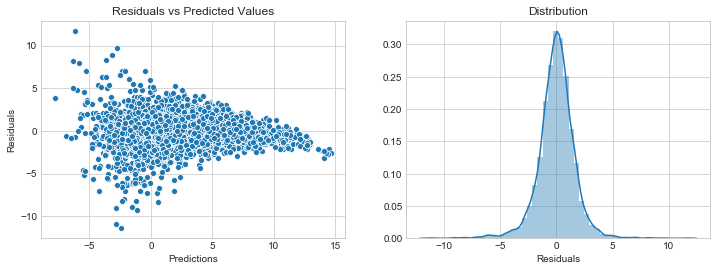

In [33]:
residuals = trained_model.summary.residuals.toPandas()["residuals"].rename("Residuals")
predictions = fitted_pipeline.transform(data).select("prediction").toPandas()["prediction"].rename("Predictions")

# Visualize
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=predictions, y=residuals)
plt.title("Residuals vs Predicted Values")
plt.subplot(1,2,2)
sns.distplot(residuals)
plt.title("Distribution")
plt.show()

## Predicting trade flows for "new" countries

Additions to the pipeline above:
* More years = more observations
* Train/test split
* Feature normalization
* Model tuning (elasticnet parameters)
* Cross validation
* Evaluation of predictions on the test set

### Load, prepare, and cache data

In [35]:
# load flows with 10 years of data
flows = spark.read.parquet("data/parquet/*")
flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter(flows["YEAR"].isin(list(range(2009, 2018)))) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "YEAR").agg({"VALUE_IN_EUROS": "sum"})

flows = flows \
    .withColumn("TRADE_VOLUME", flows["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)") \
    .fillna({"TRADE_VOLUME": 0})

# join tables
# flows
df = flows \
    .join(F.broadcast(geographies), flows["REPORTER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "REPORTER_ISO_3") \
    .withColumnRenamed("landlocked", "REPORTER_LANDLOCKED") \
    .drop("iso2", "country") \
    .join(F.broadcast(geographies), flows["PARTNER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "PARTNER_ISO_3") \
    .withColumnRenamed("landlocked", "PARTNER_LANDLOCKED") \
    .drop("iso2", "country")

# geography
df = df \
    .withColumn("LANDLOCKED_ANY", ((df["REPORTER_LANDLOCKED"] == 1) | (df["PARTNER_LANDLOCKED"] == 1)).cast(IntegerType())) \
    .drop("REPORTER_LANDLOCKED", "PARTNER_LANDLOCKED")

# gdp
df = df \
    .join(F.broadcast(gdp), (df["REPORTER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .withColumn("REPORTER_GDP", gdp["Value"]/1e6) \
    .drop("Country Name", "Country Code", "Time", "Value") \
    .join(F.broadcast(gdp), (df["PARTNER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .withColumn("PARTNER_GDP", gdp["Value"]/1e6) \
    .drop("Country Name", "Country Code", "Time", "Value") \
    .drop("Value")

# distance
df = df \
    .join(F.broadcast(distances), (df["REPORTER_ISO_3"] == distances["iso_o"]) & (df["PARTNER_ISO_3"] == distances["iso_d"]), how="inner") \
    .drop("iso_o", "iso_d") \
    .withColumnRenamed("dist", "DISTANCE") \
    .withColumnRenamed("contig", "COMMON_BORDER").withColumnRenamed("comlang_off", "COMMON_LANGUAGE")

#
data = df.drop("REPORTER_ISO_3", "PARTNER_ISO_3").cache()

### Define the pipeline

In [37]:
features = [
    "REPORTER_GDP_log", 
    "PARTNER_GDP_log", 
    "DISTANCE_log", 
    "LANDLOCKED_ANY", 
    "COMMON_BORDER", 
    "COMMON_LANGUAGE", 
    "TRADE_TYPE_idx"]

# Apply log transform to TRADE_VOLUME, REPORTER_GDP, PARTNER_GDP, DISTANCE
data = data \
    .withColumn("TRADE_VOLUME_log", F.log(df.TRADE_VOLUME)) \
    .withColumn("REPORTER_GDP_log", F.log(df.REPORTER_GDP)) \
    .withColumn("PARTNER_GDP_log", F.log(df.PARTNER_GDP)) \
    .withColumn("DISTANCE_log", F.log(df.DISTANCE))

# train/test split
data_train, data_test = data.randomSplit([0.8,0.2])

# StringIndexer
stringindexer = StringIndexer(inputCol="TRADE_TYPE", outputCol="TRADE_TYPE_idx")

# VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# MinMax scaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Regression model
model = LinearRegression(maxIter=100,
                         labelCol="TRADE_VOLUME_log", 
                         featuresCol="features",
                         fitIntercept=True)

# Define pipeline
pipeline = Pipeline(stages=[stringindexer, assembler, model])

# Tune grid
paramGrid = ParamGridBuilder() \
    .addGrid(model.maxIter, [1, 10, 50]) \
    .addGrid(model.regParam, [0.0, 0.1, 0.5, 1.0]) \
    .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Evaluator
evaluator = RegressionEvaluator(
    labelCol='TRADE_VOLUME_log', 
    predictionCol='prediction', 
    metricName='rmse')

# Cross validator
crossvalidator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3)

### Fit the pipeline / train the model

In [38]:
# Fit pipeline
fitted_pipeline = crossvalidator.fit(data_train)

### Model summary

In [39]:
# Get the best trained model from the pipeline
trained_model = fitted_pipeline.bestModel.stages[-1]

In [40]:
# Print out model summary
lr_summary(trained_model, features)

MODEL SUMMARY

           Features  Coefficients  Standard errors    t-Values  p-Values
0  REPORTER_GDP_log      1.162468         0.005795  200.608402  0.000000
1   PARTNER_GDP_log      1.074538         0.004175  257.401882  0.000000
2      DISTANCE_log     -1.143992         0.014143  -80.888701  0.000000
3    LANDLOCKED_ANY     -0.535335         0.019446  -27.529349  0.000000
4     COMMON_BORDER      0.283944         0.073162    3.881040  0.000104
5   COMMON_LANGUAGE      0.879499         0.037948   23.176275  0.000000
6    TRADE_TYPE_idx      0.554136         0.034128   16.237225  0.000000
7          constant    -12.967715         0.151894  -85.373263  0.000000

Dependent variable: TRADE_VOLUME_log
Number of observations: 34359
RMSE:       1.690448
R2:         0.811591
Iterations: 1


In [41]:
# Same parameters as before
print('maxIter:', trained_model._java_obj.getMaxIter())
print('elasticNetParam:', trained_model._java_obj.getElasticNetParam())
print('regParam:', trained_model._java_obj.getRegParam())

maxIter: 1
elasticNetParam: 0.5
regParam: 0.0


### Predict and evaluate

In [45]:
# On training data
predictions_train = fitted_pipeline.transform(data_train)
print("RMSE:", evaluator.evaluate(predictions_train))

RMSE: 1.6904483921545712


In [46]:
# On test data
predictions_test = fitted_pipeline.transform(data_test)
print("RMSE:", evaluator.evaluate(predictions_test))

RMSE: 1.685188907021387


In [47]:
# Show the full dataset incl.feature vector, scaled feature vector, and prediction column
predictions_test.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,TRADE_TYPE,YEAR,TRADE_VOLUME,LANDLOCKED_ANY,REPORTER_GDP,PARTNER_GDP,COMMON_BORDER,COMMON_LANGUAGE,DISTANCE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log,TRADE_TYPE_idx,features,prediction
0,AT,IR,E,2009,400.696622,1,384823.180705,4.603772e+05,0,0,3184.971,5.993205,12.860539,13.039801,8.066198,0.0,"[12.860539236876697, 13.039801400528876, 8.066...",6.231011
1,AT,NI,E,2012,5.405756,1,406091.530302,9.916789e+03,0,0,9931.195,1.687464,12.914334,9.201984,9.203436,0.0,"[12.914333857267618, 9.201984478563485, 9.2034...",0.868677
2,BE,LC,E,2012,1.193847,0,493399.388895,1.452550e+03,0,0,7086.583,0.177181,13.109074,7.281076,8.865959,0.0,"(13.109074244517542, 7.281076171214935, 8.8659...",-0.047625
3,BG,ES,I,2012,1666.936573,0,51595.167186,1.375823e+06,0,0,2254.799,7.418743,10.851183,14.134562,7.720816,1.0,"[10.851183287889487, 14.134562452380871, 7.720...",6.556146
4,BG,GQ,E,2015,0.227555,0,54635.643698,1.645353e+04,0,0,4563.464,-1.480363,10.908442,9.708295,8.425837,0.0,"(10.908441763730794, 9.708295135998672, 8.4258...",0.505842


In [ ]:
# MinMax scaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [320]:
# Regression model
lr = LinearRegression(
    maxIter=100,
    labelCol='TRADE_VOLUME_log', 
    featuresCol='features',
    fitIntercept=True)

In [321]:
# Define pipeline
pipeline = Pipeline(stages=[stringindexer, assembler, scaler, lr])

In [325]:
# Tune grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [1, 10, 50]) \
    .addGrid(lr.regParam, [0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [326]:
# Evaluator
evaluator = RegressionEvaluator(
    labelCol='TRADE_VOLUME_log', 
    predictionCol='prediction', 
    metricName='rmse')

In [327]:
# Cross validator
crossvalidator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3)

### Process data and train linear regression model

In [328]:
# Fit pipeline
fitted_pipeline = crossvalidator.fit(data_train)

### Model summary

In [331]:
# Get the trained model from the pipeline
trained_model = fitted_pipeline.bestModel.stages[-1]

In [333]:
# Print out model summary
lr_summary(trained_model, features)

MODEL SUMMARY

           Features  Coefficients  Standard errors    t-Values  p-Values
0  REPORTER_GDP_log      1.163319         0.005765  201.789598  0.000000
1   PARTNER_GDP_log      1.071469         0.004175  256.668198  0.000000
2      DISTANCE_log     -1.143973         0.014158  -80.798419  0.000000
3    LANDLOCKED_ANY     -0.560066         0.019447  -28.799242  0.000000
4     COMMON_BORDER      0.267345         0.073228    3.650876  0.000262
5   COMMON_LANGUAGE      0.860618         0.037614   22.879960  0.000000
6    TRADE_TYPE_idx      0.556604         0.033903   16.417607  0.000000
7          constant    -12.939581         0.151987  -85.136022  0.000000

Dependent variable: TRADE_VOLUME_log
Number of observations: 34455
RMSE:       1.690087
R2:         0.811795
Iterations: 1


In [335]:
# Same parameters as before
print('maxIter:', trained_model._java_obj.getMaxIter())
print('elasticNetParam:', trained_model._java_obj.getElasticNetParam())
print('regParam:', trained_model._java_obj.getRegParam())

maxIter: 50
elasticNetParam: 0.0
regParam: 0.0


### Predict and evaluate

In [337]:
# On training data
predictions_train = fitted_pipeline.transform(data_train)
evaluator.evaluate(predictions_train)

1.6900873108929582

In [338]:
# On test data
predictions_test = fitted_pipeline.transform(data_test)
evaluator.evaluate(predictions_test)

1.6867667680355025

In [339]:
# Show the full dataset incl.feature vector, scaled feature vector, and prediction column
predictions_test.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,TRADE_TYPE,YEAR,TRADE_VOLUME,LANDLOCKED_ANY,REPORTER_GDP,PARTNER_GDP,COMMON_BORDER,COMMON_LANGUAGE,DISTANCE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log,TRADE_TYPE_idx,features,scaledFeatures,prediction
0,AT,DK,I,2015,1317.254393,1,413554.595891,343294.474736,0,0,868.5304,7.183305,12.932545,12.746344,6.766803,1.0,"[12.932544818324901, 12.746343884751296, 6.766...","[0.6346986261814701, 0.7030248306052643, 0.462...",8.017890
1,AT,EE,I,2015,168.766293,1,413554.595891,23378.735867,0,0,1360.3580,5.128515,12.932545,10.059582,7.215503,1.0,"[12.932544818324901, 10.059582164557709, 7.215...","[0.6346986261814701, 0.499617590318478, 0.5397...",4.625808
2,AT,NI,E,2012,5.405756,1,406091.530302,9916.789200,0,0,9931.1950,1.687464,12.914334,9.201984,9.203436,0.0,"[12.914333857267618, 9.201984478563485, 9.2034...","[0.6317284967896557, 0.4346912601294913, 0.882...",0.854988
3,BG,LR,E,2014,1.704936,0,52802.761608,2555.669829,0,0,5247.0310,0.533528,10.874319,7.846070,8.565418,0.0,"(10.874318771512776, 7.846069632461148, 8.5654...","[0.29901081391251005, 0.33203872684504104, 0.7...",-1.681077
4,BG,UA,E,2012,885.844610,0,51595.167186,143789.379505,0,0,1022.5530,6.786542,10.851183,11.876105,6.930058,0.0,"(10.851183287889487, 11.876104865526399, 6.930...","[0.29523751607901166, 0.6371414603160444, 0.49...",4.480873
